In [1]:
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize
from tqdm import tqdm
import pickle
import scipy.stats as st
import scipy.interpolate as interp
import numexpr as ne
from scipy.optimize import minimize, curve_fit
import argparse as ap
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *

read icdata
read uptdata
read eadata
read mspdata


In [2]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.379113,3.31,0.480000,203.024000,16.760000,218.374000,106.712000
1,54562.386622,5.17,0.620000,75.024000,-13.371000,349.100000,76.646000
2,54562.387892,3.92,0.560000,97.501000,11.290000,327.060000,101.291000
3,54562.392677,5.57,1.130000,305.857000,-33.932000,120.413000,56.090000
4,54562.404776,5.80,1.110000,143.516000,-38.279000,287.171000,51.684000
...,...,...,...,...,...,...,...
1840455,58262.032910,-1.00,31.988022,302.275278,-36.011183,35.898986,35.961828
1840456,58261.083268,-1.00,-5.090167,280.296803,9.032133,-3.352477,-9.040424
1840457,58114.383533,-1.00,7.833750,103.792616,-4.151254,216.646146,4.169148
1840458,57894.658905,-1.00,50.282026,335.406679,-47.888174,205.726267,47.787900


In [3]:
print(icwidths)

[69558, 107011, 93133, 229976, 205070, 217831, 227278, 227067, 213654, 249882]


In [2]:
cone_deg = 5
cone = np.deg2rad(cone_deg)
cut = cone

In [3]:
num_threads = int(mul.cpu_count())
set_num_threads(num_threads)



# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

cone_deg = 5.0

cone = np.deg2rad(cone_deg)
cut = cone

print('#'*50)
print("Cone angle: ", cone_deg)
# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
nbins = 1e7


enus = np.logspace(11.001, 18.999, int(nbins))
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1
msdec_bin_indices = np.zeros(p, dtype=np.int64)
for i in prange(p):
    msdec_bin_indices[i] = np.digitize(msdec[i], dec_nu) - 1

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) - 1
gamma_arr = [-2, -2.2, -2.53, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")
eareaa = [i.astype(np.float64) for i in earea]
eareaa = np.asfarray(eareaa, dtype=np.float64)
eareaa[0][0]
earea2 = np.asfortranarray(earea)
earea2 = earea2[0].astype(np.float64)


altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = msdec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * (enus[i]**gamma))


    return np.trapz(wt_ac_temp, enus)

if f'wt_acc_{len(enus)}_bins_C_wt.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins_C_wt.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
    

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins_C_wt.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all pulsars and seasons and gamma")
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

w_models = np.array([np.ones(p)])

@njit(nogil=True, parallel=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    
    
    
    # ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    # sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    # return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2
    
    #SUGGESTION 0: SIGNAL PDF USES A CUT = CONE OF BGND PDF
    ang = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True)
    
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    psr_angs =  np.divide(np.exp(-1 * np.divide(ang ** 2, 2*sg)), (2 * np.pi * sg))      #1/rad**2
    for i in prange(p):
        if ang[i] > cone:
            psr_angs[i] = 0
            
    return psr_angs
    


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2

@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)


@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=cone):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi_C_cone_{cone_deg}.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi_C_cone_{cone_deg}.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi_C_cone_{cone_deg}.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)
        

@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
   

    tt_upt = t_upt[season]

        
    l = msdec_bin_indices[psrno]
     
        
    ns_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)
    # temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
    # return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV

    return np.trapz(ns_temp, enus) 


wt_acc.shape


# @njit(nogil=True)
# def TS_for_all_psrs2(nsa):  
#     return Ts_arr2(nsa, t2mp, all_Bi, Ns) 


@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)





# # W_MODEL=1 ONLY


if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    # tmp = []
    tmp_wt_acc = []
    # tmp_wt_acc_w_dist = []
    # tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        # tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        # tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        # tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    # all_Si_ws_g_s.append([tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    all_Si_ws_g_s.append([tmp_wt_acc])
    # tmp = []
    tmp_wt_acc = []
    # tmp_wt_acc_w_dist = []
    # tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins_C_wt_bins_C_wt_all_psr_wmod1_cone_{cone_deg}.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)


##################################################
Cone angle:  5.0

Number of energy bins:  10000000

Number of phi bins:  1000

Calculating weights...


Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  10000000
Loading all_Bi from pickle...
Loaded all_Bi from pickle
Loading all_Si_ws_g_s from pickle
Loaded all_Si_ws_g_s from pickle with nbins = 10000000


In [44]:
nu = 1500
def ns_for_TSmax(S, B, Ns):
    
    '''
    Parameters
    ----------
    
    S : float
        Signal PDF
    B : float
        Background PDF
    
    Ns : int
        No.of neutrinos used for analysis
    
    Returns
    -------
    Returns the value of $n_s$ for which
    the TS is maximum for the given Signal,
    Background parameters of a pulsar
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS_st_vec(x, S, B, Ns)
    soln = minimize(nll, 6 ,bounds=((0,None),), tol=1e-12)
    ns = float(soln.x)
    return ns


In [47]:
def maxns_driver(i):
    return [ns_for_TSmax(all_Si_ws_g_s[0][1][i], all_Bi[i], Ns), ns_for_TSmax(all_Si_ws_g_s[0][2][i], all_Bi[i], Ns), ns_for_TSmax(all_Si_ws_g_s[0][3][i], all_Bi[i], Ns)]


pool = mul.Pool(12)



op_async = pool.map_async(maxns_driver, range(lnu), chunksize=1000)
maxns_wmodel1_all_gamma = op_async.get()

In [48]:
maxns_wmodel1_all_gamma = np.asarray(maxns_wmodel1_all_gamma)

In [49]:
maxns_wmodel1_all_gamma.T

array([[0.00000000e+00, 0.00000000e+00, 4.44091443e+07, ...,
        0.00000000e+00, 8.88178420e-16, 8.88178420e-16],
       [0.00000000e+00, 0.00000000e+00, 5.88280724e+07, ...,
        0.00000000e+00, 8.88178420e-16, 8.88178420e-16],
       [0.00000000e+00, 0.00000000e+00, 3.09703728e+07, ...,
        0.00000000e+00, 0.00000000e+00, 8.88178420e-16]])

In [50]:
maxts_wmodel1_all_gamma = []
for i in prange(1, 4):
    temp = []
    for j in tqdm(prange(lnu)):
        temp.append( TS_st_vec(maxns_wmodel1_all_gamma.T[i-1][j], all_Si_ws_g_s[0][i][j], all_Bi[j], Ns))
    maxts_wmodel1_all_gamma.append(temp)

100%|██████████| 1134450/1134450 [00:01<00:00, 786076.41it/s]


In [51]:
maxts_wmodel1_all_gamma = np.asarray(maxts_wmodel1_all_gamma)

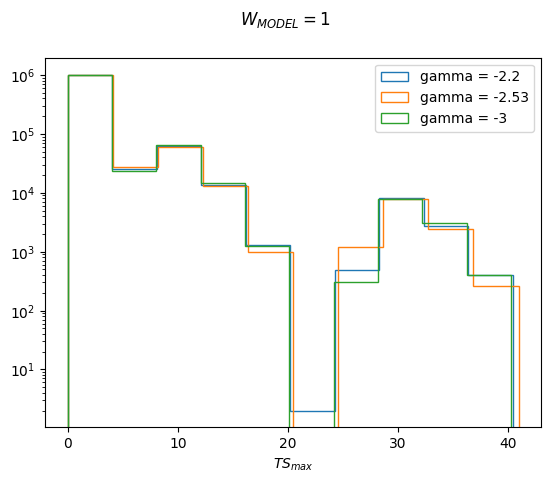

In [61]:
np.shape(maxns_wmodel1_all_gamma)

for i in range(3):
    plt.hist(maxts_wmodel1_all_gamma[i], bins=10, histtype='step', label=f'gamma = {gamma_arr[i+1]}', density=False)
    
plt.legend()
plt.xlabel('$TS_{max}$')
plt.yscale('log')
plt.suptitle('$W_{MODEL}=1$')
plt.show()

In [58]:
maxts_wmodel1_all_gamma.shape

(3, 1134450)

In [59]:
for i in range(3):
    print(np.histogram(maxts_wmodel1_all_gamma[i], bins=10, density=False))

(array([1020848,   25157,   61873,   13519,    1318,       2,     486,
          8096,    2745,     406]), array([-6.19783143e-06,  4.04004974e+00,  8.08010567e+00,  1.21201616e+01,
        1.61602175e+01,  2.02002735e+01,  2.42403294e+01,  2.82803853e+01,
        3.23204413e+01,  3.63604972e+01,  4.04005532e+01]))
(array([1020521,   27464,   60765,   13063,     997,       0,    1185,
          7725,    2471,     259]), array([-6.23163663e-06,  4.09267529e+00,  8.18535681e+00,  1.22780383e+01,
        1.63707199e+01,  2.04634014e+01,  2.45560829e+01,  2.86487644e+01,
        3.27414460e+01,  3.68341275e+01,  4.09268090e+01]))
(array([1018417,   23461,   64951,   14729,    1263,       0,     309,
          7902,    3018,     400]), array([-6.21712295e-06,  4.02322872e+00,  8.04646366e+00,  1.20696986e+01,
        1.60929335e+01,  2.01161685e+01,  2.41394034e+01,  2.81626383e+01,
        3.21858733e+01,  3.62091082e+01,  4.02323432e+01]))


In [ ]:
binnedsts, wsts = np.histogram(sqrtts, 10)

ne01 = 3
amp  = p/3.0#np.sum(binnedsts)/ne01
#binnedsts = binnedsts/amp
yerr = np.sqrt(binnedsts)
b2 = binnedsts[(binnedsts>10)]
yerr2 = yerr[(binnedsts>10)]
x=0.5*(wsts[1:]+ wsts[:-1])
x2 = x[(binnedsts>10)]
xerr=x[0]-wsts[0]
# PLOTTING THE GAUSSIAN FIT
def gaussian(x,mean,sd):
    '''Returns the gaussian PDF value at for the given mean and standard deviation'''
#    mean=0.114
    A=p/3.0
    return A*np.exp(-(x - mean) ** 2.0 / sd ** 2.0)
loggaussian = lambda x, mean, var:  np.log(gaussian(x, mean, var))
gparam, gerr = curve_fit(gaussian, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 10000, method='dogbox')
gx = np.linspace(0, wsts[-1], 100)
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize=17, fontweight='bold')

plt.errorbar(x, binnedsts, xerr=xerr,yerr=yerr,  aa = True, barsabove = True, fmt='ob',ecolor='blue', elinewidth=1.35, label='$\sqrt{TS_{max}}$')
plt.plot(gx,gaussian(gx, gparam[0], gparam[1]),'--', alpha=0.6, label=f'Gaussian Fit', color='darkred', lw=2.2)

plt.xlabel("$\mathbf{\sqrt{TS_{max}}}$", fontweight='bold', fontdict=font)
plt.ylabel("No.of Events", fontweight='bold', fontdict=font)
#plt.grid(True, which='major')
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.savefig("outputs/sqrt(TSmax)final.jpg")